In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import joblib
import datetime as dt

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torch.nn.functional as F
import torchvision
import torchvision.models as models

#from skimage import io
import sklearn
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss, f1_score, confusion_matrix, classification_report
from sklearn import metrics, preprocessing
from scipy.ndimage import zoom

import timm
import albumentations as A
import albumentations.pytorch
import wandb
from catalyst.data.sampler import BalanceClassSampler
from torch.utils.data.distributed import DistributedSampler

#### Hyper Param Setting

In [2]:
CFG = {
    'fold_num': 5,
    'seed': 42,
    't_model': 'resnet152',
    'load_model': 'resnet152_20230427223000', # LOAD TEACHER MODEL
    's_model': 'mobilenet_v3_large',
    'img_size': 260,
    'alpha': 0.5,
    'epochs': 200,
    'train_bs':64,
    'valid_bs':64,
    'lr': 1e-4, ## learning rate
    'num_workers': 8,
    'verbose_step': 1,
    'patience' : 5,
    'device': 'cuda:0',
    'freezing': False,
    'trainable_layer': 6,
    'model_path': './models'
}

#### wandb init

In [3]:
time_now = dt.datetime.now()
run_id = time_now.strftime("%Y%m%d%H%M%S")
project_name = 'KD_mobilenet_resnet152' + run_id
user = 'hojunking'
run_name = project_name

In [4]:
main_path = '../Data/carbon_data/'
label_list = ["10Kwalk","battery",'box','else','bottle','handkerchief',
              'milk', 'paper', 'pet','plug','receipt', 'shopping bag', 'stairs',
             'transportation', 'trash picking', 'plate']

total_train_img_paths = []
total_train_img_labels = []
total_test_img_paths = []
total_test_img_labels = []

for label in label_list: ## 각 레이블 돌기
    print(f'label: {label}')
    img_paths = [] 
    img_labels = []

    # default ratio
    train_ratio = 1500
    test_ratio = 500

    dir_path = main_path + label ## 레이블 폴더 경로
    count = 0
    for folder, subfolders, filenames in os.walk(dir_path): ## 폴더 내 모든 파일 탐색
    
        for img in filenames: ## 각 파일 경로, 레이블 저장
            count +=1
            if count > train_ratio + test_ratio + 10000:
                break
            
            img_paths.append(folder+'/'+img)
            img_labels.append(label)
        
    random.shuffle(img_paths)
    print(f'img_paths len : {len(img_paths)}\n')

    if label == 'else': ## 10walking 데이터 비율 설정하기 (데이터수: 2494)
        train_ratio = 3000
        test_ratio = 745
    elif label == 'plate': 
        train_ratio = 4349
        test_ratio = 1000
    elif label == 'handkerchief':
        train_ratio = 2000
        test_ratio = 433     
    elif label == 'milk':
        train_ratio = 2000
        test_ratio = 374
    elif label == 'paper':
        train_ratio = 1300
        test_ratio = 365
    elif label == 'pet':
        train_ratio = 2000
        test_ratio = 402
    elif label == 'plug':
        train_ratio = 2200
        test_ratio = 725
    elif label == 'receipt':
        train_ratio = 600
        test_ratio = 243 
    elif label == 'shopping bag':
        train_ratio = 1300
        test_ratio = 413
    elif label == 'stairs':
        train_ratio = 3000
        test_ratio = 1057
    elif label == 'bottle':
        train_ratio = 4652
        test_ratio = 1500
    elif label == 'transportation':
        train_ratio = 1800
        test_ratio = 435
    elif label == 'trash picking':
        train_ratio = 1300
        test_ratio = 327
    elif label == '10Kwalk':
        train_ratio = 1556
        test_ratio = 400
    elif label == 'battery':
        train_ratio = 2305
        test_ratio = 500
    elif label == 'box':
        train_ratio = 1600
        test_ratio = 388
        
    total_train_img_paths.extend(img_paths[:train_ratio])
    total_train_img_labels.extend(img_labels[:train_ratio])

    total_test_img_paths.extend(img_paths[-test_ratio:])
    total_test_img_labels.extend(img_labels[-test_ratio:])

print('Train_Images: ',len(total_train_img_paths))
print("Train_Images_labels:", len(total_train_img_labels))
print('Test_Images: ',len(total_test_img_paths))
print("Test_Images_labels:", len(total_test_img_labels))

label: 10Kwalk
img_paths len : 1956

label: battery
img_paths len : 2805

label: box
img_paths len : 1988

label: else
img_paths len : 3785

label: bottle
img_paths len : 6152

label: handkerchief
img_paths len : 2433

label: milk
img_paths len : 2375

label: paper
img_paths len : 1665

label: pet
img_paths len : 2404

label: plug
img_paths len : 2931

label: receipt
img_paths len : 843

label: shopping bag
img_paths len : 1713

label: stairs
img_paths len : 4061

label: transportation
img_paths len : 2236

label: trash picking
img_paths len : 1628

label: plate
img_paths len : 5349

Train_Images:  34962
Train_Images_labels: 34962
Test_Images:  9307
Test_Images_labels: 9307


In [5]:
## Pandas 데이터프레임 만들기
trn_df = pd.DataFrame(total_train_img_paths, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = total_train_img_labels
train = trn_df
train

,image_id,dir,label
0,10Kwalk_1213.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_1069.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_637.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_742.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_446.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
34957,wrap_537.jpg,../Data/carbon_data/plate/wrap,plate
34958,leftover_1692.jpg,../Data/carbon_data/plate/leftover,plate
34959,leftover_1516.jpg,../Data/carbon_data/plate/leftover,plate
34960,leftover_836.jpg,../Data/carbon_data/plate/leftover,plate


In [6]:
# Label Encoding
le = preprocessing.LabelEncoder()
train['label'] = le.fit_transform(train['label'].values)

In [7]:
train.label.value_counts()

2     4652
9     4349
4     3000
13    3000
1     2305
10    2200
5     2000
6     2000
8     2000
14    1800
3     1600
0     1556
7     1300
12    1300
15    1300
11     600
Name: label, dtype: int64

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [9]:
def get_img(path, sub_path=None):
    try:
        im_bgr = cv2.imread(path)
        im_rgb = im_bgr[:, :, ::-1]
        past_path = path
    except: ## 이미지 에러 발생 시 백지로 대체
        im_bgr = cv2.imread('../Data/carbon_reduction/temp_img.jpg')
        im_rgb = im_bgr[:, :, ::-1]
    return im_rgb

In [10]:
transform_train = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.75),ratio=(0.90, 1.10)),
        A.SafeRotate(p=0.5, limit=(-20, 20), interpolation=2, border_mode=0, value=(0, 0, 0), mask_value=None),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(always_apply=True, p=0.5, contrast=0.2, saturation=0.3, hue=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_train_cap = A.Compose(
    [
        A.RandomResizedCrop(p=1, height=CFG['img_size'] ,width=CFG['img_size'], scale=(0.65, 0.85),ratio=(0.90, 1.10)),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

transform_test = A.Compose(
    [
        A.Resize(height = CFG['img_size'], width = CFG['img_size']),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
        A.pytorch.transforms.ToTensorV2()
        ])

In [11]:
class ColonDataset(Dataset):
    def __init__(self, df, data_root, transform=None, transform2=None, output_label=True):
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transform = transform
        self.transform2 = transform2
        self.data_root = data_root
        self.output_label = output_label
        
        if output_label == True:
            self.labels = self.df['label'].values
        
        # EXEPTION TRANSFORM FOR CAPTURE IMAGES
        self.cap_image = le.fit_transform(['10Kwalk', 'battery','receipt'])
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        # GET labels
        if self.output_label:
            target = self.labels[index]
        # GET IMAGES
        path = "{}/{}".format(self.data_root[index], self.df.iloc[index]['image_id'])
        img  = get_img(path)
        
        # TRANSFORM1, TRANSFORM2 PROCESS
        if self.transform2 :
            if target in self.cap_image and self.transform2:
                transformed = self.transform2(image=img)
            else:
                transformed = self.transform(image=img)
        elif self.transform:
            transformed = self.transform(image=img)
        img = transformed['image']
                
        if self.output_label == True:
            return img, target
        else:
            return img

In [12]:
# class ForcepImgClassifier(nn.Module):
#     def __init__(self, model_arch, n_class=2, pretrained=False):
#         super().__init__()
#         self.model = timm.create_model(model_arch, pretrained=pretrained, num_classes=n_class)
#         # n_features = self.model.classifier.in_features
#         # self.model.classifier = nn.Linear(n_features, n_class)
#     def freezing(self, freeze=False, trainable_layer = 2):
        
#         if freeze:
#             num_layers = len(list(model.parameters()))
#             for i, param in enumerate(model.parameters()):
#                 if i < num_layers - trainable_layer*2:
#                     param.requires_grad = False    
            
#     def forward(self, x):
#         x = self.model(x)
#         return x

In [13]:
# LOAD PRE-TRAINED MODEL
class Student(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Student, self).__init__()
        self.backbone = models.mobilenet_v3_large(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.classifier[-1] = nn.Linear(self.backbone.classifier[-1].in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [14]:
# LOAD PRE-TRAINED MODEL
class Teacher(nn.Module):
    def __init__(self, model_arch, num_classes= 2,pretrained=True):
        super(Teacher, self).__init__()
        self.backbone = models.resnet152(pretrained=pretrained) ## 모델 선언 여기 models.##(pretrained =pretrained)
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

In [15]:
def prepare_dataloader(df, trn_idx, val_idx, data_root=train.dir.values):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
    train_data_root = data_root[trn_idx]
    valid_data_root = data_root[val_idx]
    
        
    train_ds = ColonDataset(train_,
                            train_data_root,
                            transform=transform_train,
                            transform2=transform_train_cap,
                            output_label=True)
    valid_ds = ColonDataset(valid_,
                            valid_data_root,
                            transform=transform_test,
                            output_label=True)
    # WEIGHTEDRANDOMSAMPLER
    class_counts = train_.label.value_counts(sort=False).to_dict()
    num_samples = sum(class_counts.values())
    print(f'cls_cnts: {len(class_counts)}\nnum_samples:{num_samples}')
    
    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}
    t_labels = train_.label.to_list()
    
    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))]


    # weight 제작, 전체 학습 데이터 수를 해당 클래스의 데이터 수로 나누어 줌
    class_weights = {l:round(num_samples/class_counts[l], 2) for l in class_counts.keys()}

    # class 별 weight를 전체 trainset에 대응시켜 sampler에 넣어줌
    weights = [class_weights[t_labels[i]] for i in range(int(num_samples))] 
    sampler = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights), int(num_samples))
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True,
        drop_last=False,
        shuffle=False,
        sampler=sampler, 
        num_workers=CFG['num_workers']
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

In [16]:
# def distill_loss(student_logits, labels, teacher_logits, criterion, alpha=0.1):
#     # TEACHER & STUDENT LOSS
#     distillation_loss = criterion(student_logits, teacher_logits)
    
#     # STUDENT & LABEL LOSS
#     student_loss = criterion(student_logits, labels)
#     loss_b = alpha * student_loss + (1-alpha) * distillation_loss

#     return loss_b

In [17]:
def distill_loss(student_logits, labels, teacher_logits, criterion, alpha=0.1, temperature=2):
    # STUDENT & LABEL LOSS
    student_loss = criterion(student_logits, labels)

    # TEACHER & STUDENT LOSS
    teacher_probs = F.softmax(teacher_logits / temperature, dim=1)
    student_probs = F.softmax(student_logits / temperature, dim=1)
    distillation_loss = F.kl_div(torch.log(student_probs), teacher_probs, reduction="batchmean") * (temperature ** 2)

    # FINAL LOSS
    loss_b = alpha * student_loss + (1 - alpha) * distillation_loss
    return loss_b


In [18]:
def train_one_epoch(epoch, s_model, t_model, loss_tr, optimizer, train_loader, device, scheduler=None, alpha =0.1):
    t = time.time()

    # SET MODEL TRAINING MODE
    s_model.train()
    t_model.eval()
    
    running_loss = None
    loss_sum = 0
    student_preds_all = []
    image_targets_all = []
    acc_list = []
    
    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        optimizer.zero_grad()
        
        # STUDENT MODEL PREDICTION
        with torch.cuda.amp.autocast():
            student_preds = s_model(imgs)
            
            # TEACHER MODEL DISTILLATION (NO UPDATE)
            with torch.no_grad():
                teacher_preds = t_model(imgs)
            
            # DISTILLATION LOSS
            loss = distill_loss(student_preds, image_labels, teacher_preds, loss_tr, alpha)
            loss_sum+=loss.detach()
            
            # BACKPROPAGATION
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01    
            
            # TQDM VERBOSE_STEP TRACKING
            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)
        
        student_preds_all += [torch.argmax(student_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
    if scheduler is not None:
        scheduler.step()
    
    student_preds_all = np.concatenate(student_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    
    matrix = confusion_matrix(image_targets_all,student_preds_all)
    epoch_f1 = f1_score(image_targets_all, student_preds_all, average='macro')
    accuracy = (student_preds_all==image_targets_all).mean()
    trn_loss = loss_sum/len(train_loader)
    
    return student_preds_all, accuracy, trn_loss, matrix, epoch_f1

def valid_one_epoch(epoch,s_model, t_model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False, alpha =0.1):
    ## Sets the model to valid mode
    s_model.eval()
    t_model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    avg_loss = 0
    student_preds_all = []
    image_targets_all = []
    
    acc_list = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        student_preds = s_model(imgs)   #output = model(input)
        teacher_preds = t_model(imgs) # teacher prediction
        
        loss = distill_loss(student_preds, image_labels, teacher_preds, loss_fn, alpha)
        
        student_preds_all += [torch.argmax(student_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        avg_loss += loss.item()
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]
        
        description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
        pbar.set_description(description)
    
    student_preds_all = np.concatenate(student_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    matrix = confusion_matrix(image_targets_all,student_preds_all)
    
    epoch_f1 = f1_score(image_targets_all, student_preds_all, average='macro')
    acc = (student_preds_all==image_targets_all).mean()
    val_loss = avg_loss/len(val_loader)
    
    return student_preds_all, acc, val_loss, matrix, epoch_f1

#### Early Stopping

In [19]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score <= self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            print(f'Best F1 score from now: {self.best_score}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        
        return self.early_stop

In [ ]:
if __name__ == '__main__':
    seed_everything(CFG['seed'])
    
    # WANDB TRACKER INIT
    wandb.init(project=project_name, entity=user)
    wandb.config.update(CFG)
    wandb.run.name = run_name
    wandb.define_metric("Train Accuracy", step_metric="epoch")
    wandb.define_metric("Valid Accuracy", step_metric="epoch")
    wandb.define_metric("Train Loss", step_metric="epoch")
    wandb.define_metric("Valid Loss", step_metric="epoch")
    wandb.define_metric("Train Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Valid Macro F1 Score", step_metric="epoch")
    wandb.define_metric("Train-Valid Accuracy", step_metric="epoch")
    
    model_dir = CFG['model_path'] + '/{}_{}'.format(CFG['s_model'], run_id)
    train_dir = train.dir.values
    best_fold = 0
    best_f1 =0.0
    
    print('Model: {}'.format(CFG['s_model']))
    # MAKE MODEL DIR
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    
    
    # STRATIFIED K-FOLD DEFINITION
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    for fold, (trn_idx, val_idx) in enumerate(folds):
        print(f'Training start with fold: {fold} epoch: {CFG["epochs"]} \n')

        # EARLY STOPPING DEFINITION
        early_stopping = EarlyStopping(patience=CFG["patience"], verbose=True)

        # DATALOADER DEFINITION
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root=train_dir)

        # MODEL & DEVICE DEFINITION 
        device = torch.device(CFG['device'])
        #student_model = ForcepImgClassifier(CFG['s_model'], train.label.nunique(), pretrained=True)
        #teacher_model = ForcepImgClassifier(CFG['t_model'], train.label.nunique(), pretrained=True)
        student_model = Student(CFG['s_model'], train.label.nunique(), pretrained=True)
        teacher_model = Teacher(CFG['t_model'], train.label.nunique(), pretrained=True)
        
        # T_MODEL DATA PARALLEL
        teacher_model.to(device)
        if torch.cuda.device_count() > 1:
            teacher_model = nn.DataParallel(teacher_model)

        # LOAD TEACHER_MODE WEIGHT
        load_model = CFG['model_path'] +'/' + CFG['load_model'] + '/' + CFG['t_model']
        teacher_model.load_state_dict(torch.load(load_model))

        # MODEL FREEZING
        # student_model.freezing(freeze = CFG['freezing'], trainable_layer = CFG['trainable_layer'])
        # if CFG['freezing'] ==True:
        #     for name, param in student_model.named_parameters():
        #         if param.requires_grad == True:
        #             print(f"{name}: {param.requires_grad}")

        # S_MODEL DATA PARALLEL
        student_model.to(device)
        if torch.cuda.device_count() > 1:
            student_model = nn.DataParallel(student_model)

        scaler = torch.cuda.amp.GradScaler()   
        optimizer = torch.optim.Adam(student_model.parameters(), lr=CFG['lr'])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.5, step_size=5)

        # DISTILLATION RATE
        alpha = CFG['alpha']

        # CRITERION (LOSS FUNCTION)
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        wandb.watch(student_model, loss_tr, log='all')

        train_acc_list = []
        train_matrix_list = []
        train_f1_list = []
        valid_acc_list = []
        valid_matrix_list = []
        valid_f1_list = []

        start = time.time()
        print(f'Fold: {fold}\n')
        for epoch in range(CFG['epochs']):
            print('Epoch {}/{}'.format(epoch, CFG['epochs'] - 1))

            # TRAINIG
            train_preds_all, train_acc, train_loss, train_matrix, train_f1 = train_one_epoch(epoch, student_model, teacher_model,loss_tr, optimizer, train_loader, device, scheduler=scheduler, alpha = alpha)
            wandb.log({'Train Accuracy':train_acc, 'Train Loss' : train_loss, 'Train F1': train_f1, 'epoch' : epoch})

            # VALIDATION
            with torch.no_grad():
                valid_preds_all, valid_acc, valid_loss, valid_matrix, valid_f1= valid_one_epoch(epoch, student_model, teacher_model, loss_fn, val_loader, device, scheduler=None, alpha = alpha)
                wandb.log({'Valid Accuracy':valid_acc, 'Valid Loss' : valid_loss, 'Valid F1': valid_f1 ,'epoch' : epoch})
            print(f'Epoch [{epoch}], Train Loss : [{train_loss :.5f}] Val Loss : [{valid_loss :.5f}] Val F1 Score : [{valid_f1:.5f}]')

            # SAVE ALL RESULTS
            train_acc_list.append(train_acc)
            train_matrix_list.append(train_matrix)
            train_f1_list.append(train_f1)

            valid_acc_list.append(valid_acc)
            valid_matrix_list.append(valid_matrix)
            valid_f1_list.append(valid_f1)

            # MODEL SAVE (THE BEST MODEL OF ALL OF FOLD PROCESS)
            if valid_f1 > best_f1:
                best_f1 = valid_f1
                torch.save(student_model.state_dict(), (model_dir+'/{}').format(CFG['s_model']))

            # EARLY STOPPING
            stop = early_stopping(valid_f1)
            if stop:
                print("stop called")   
                break

        end = time.time() - start
        time_ = str(datetime.timedelta(seconds=end)).split(".")[0]
        print("time :", time_)

        # PRINT BEST F1 SCORE MODEL OF FOLD
        best_index = valid_f1_list.index(max(valid_f1_list))
        print(f'fold: {fold}, Best Epoch : {best_index}/ {len(valid_f1_list)}')
        print(f'Best Train Marco F1 : {train_f1_list[best_index]:.5f}')
        print(train_matrix_list[best_index])
        print(f'Best Valid Marco F1 : {valid_f1_list[best_index]:.5f}')
        print(valid_matrix_list[best_index])
        print('-----------------------------------------------------------------------')

        ## K-FOLD END
        if valid_f1_list[best_index] > best_fold:
            best_fold = valid_f1_list[best_index]
            top_fold = fold
    print(f'Best Fold F1 score: {best_fold} Top fold : {top_fold}')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hojunking. Use `wandb login --relogin` to force relogin


Model: mobilenet_v3_large
Training start with fold: 0 epoch: 200 

cls_cnts: 16
num_samples:27969


/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1

Fold: 0

Epoch 0/199


epoch 0 loss: 0.7067: 100%|███████████████████| 110/110 [02:32<00:00,  1.39s/it]

Epoch [0], Train Loss : [1.62077] Val Loss : [0.70387] Val F1 Score : [0.89784]
Epoch 1/199



epoch 1 loss: 0.5816: 100%|███████████████████| 110/110 [02:38<00:00,  1.44s/it]

Epoch [1], Train Loss : [0.59279] Val Loss : [0.58067] Val F1 Score : [0.91824]
Epoch 2/199



epoch 2 loss: 0.5258: 100%|███████████████████| 110/110 [02:40<00:00,  1.46s/it]

Epoch [2], Train Loss : [0.47191] Val Loss : [0.52394] Val F1 Score : [0.93086]
Epoch 3/199



epoch 3 loss: 0.5408: 100%|███████████████████| 110/110 [02:35<00:00,  1.41s/it]

Epoch [3], Train Loss : [0.40348] Val Loss : [0.53901] Val F1 Score : [0.92608]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9308618101637917
Epoch 4/199



epoch 4 loss: 0.4799: 100%|███████████████████| 110/110 [02:38<00:00,  1.44s/it]

Epoch [4], Train Loss : [0.34208] Val Loss : [0.47873] Val F1 Score : [0.93745]
Epoch 5/199



epoch 5 loss: 0.4684: 100%|███████████████████| 110/110 [02:33<00:00,  1.39s/it]

Epoch [5], Train Loss : [0.30546] Val Loss : [0.46699] Val F1 Score : [0.93534]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9374492241306904
Epoch 6/199



epoch 6 loss: 0.4411: 100%|███████████████████| 110/110 [02:40<00:00,  1.46s/it]

Epoch [6], Train Loss : [0.27269] Val Loss : [0.43942] Val F1 Score : [0.94355]
Epoch 7/199



epoch 7 loss: 0.4413: 100%|███████████████████| 110/110 [02:33<00:00,  1.40s/it]

Epoch [7], Train Loss : [0.25319] Val Loss : [0.43930] Val F1 Score : [0.94156]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9435466767536864
Epoch 8/199



epoch 8 loss: 0.4258: 100%|███████████████████| 110/110 [02:36<00:00,  1.42s/it]

Epoch [8], Train Loss : [0.24577] Val Loss : [0.42405] Val F1 Score : [0.94267]
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9435466767536864
Epoch 9/199



epoch 9 loss: 0.4201: 100%|███████████████████| 110/110 [02:36<00:00,  1.42s/it]

Epoch [9], Train Loss : [0.22868] Val Loss : [0.41870] Val F1 Score : [0.94488]
Epoch 10/199



epoch 10 loss: 0.4065: 100%|██████████████████| 110/110 [02:41<00:00,  1.46s/it]


Epoch [10], Train Loss : [0.21341] Val Loss : [0.40487] Val F1 Score : [0.94744]
Epoch 11/199


epoch 11 loss: 0.4052: 100%|██████████████████| 110/110 [02:37<00:00,  1.43s/it]

Epoch [11], Train Loss : [0.20587] Val Loss : [0.40362] Val F1 Score : [0.94829]
Epoch 12/199



epoch 12 loss: 0.4013: 100%|██████████████████| 110/110 [02:34<00:00,  1.41s/it]

Epoch [12], Train Loss : [0.19628] Val Loss : [0.39985] Val F1 Score : [0.94789]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9482861962971243
Epoch 13/199



epoch 13 loss: 0.4073: 100%|██████████████████| 110/110 [02:40<00:00,  1.46s/it]

Epoch [13], Train Loss : [0.18563] Val Loss : [0.40554] Val F1 Score : [0.94752]
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9482861962971243
Epoch 14/199



epoch 14 loss: 0.3988: 100%|██████████████████| 110/110 [02:38<00:00,  1.44s/it]

Epoch [14], Train Loss : [0.19031] Val Loss : [0.39718] Val F1 Score : [0.94708]
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9482861962971243
Epoch 15/199



epoch 15 loss: 0.3965: 100%|██████████████████| 110/110 [02:35<00:00,  1.42s/it]

Epoch [15], Train Loss : [0.18442] Val Loss : [0.39478] Val F1 Score : [0.94704]
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9482861962971243
Epoch 16/199



epoch 16 loss: 0.3939: 100%|██████████████████| 110/110 [02:35<00:00,  1.42s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

Epoch [16], Train Loss : [0.17928] Val Loss : [0.39224] Val F1 Score : [0.94788]
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9482861962971243
stop called
time : 3:03:33
fold: 0, Best Epoch : 11/ 17
Best Train Marco F1 : 0.97718
[[1790    3    1    0    2    0    0    0    0    0    0    0    0    0
     1    0]
 [   7 1754    0    0    3    0    0    1    0    1    3    6    0    0
     0    0]
 [   1    0 1729    0    1    1    0    0    8    5    2    0    2    1
     0    1]
 [   0    0    1 1766   10    1   12    3    6    0    0    0    0    0
     3    2]
 [   4    3    5    8 1454    7   10    7   11   79    6   11   11    1
     7    3]
 [   0    0    2    1    3 1762    1    2    0    5    1    0    6    1
     0    5]
 [   0    0    2    9    8    1 1753    2    1    1    1    0    3    0
     1    2]
 [   0    0    0    6    6    1    2 1678    0    1    5    1    2    1
     3    2]
 [   0    0    8   11    8    0    2    0 1717    3    1    0    3    1
    

epoch 0 loss: 0.6924: 100%|███████████████████| 110/110 [02:28<00:00,  1.35s/it]

Epoch [0], Train Loss : [1.58310] Val Loss : [0.69560] Val F1 Score : [0.90357]
Epoch 1/199



epoch 1 loss: 0.5733: 100%|███████████████████| 110/110 [02:27<00:00,  1.35s/it]

Epoch [1], Train Loss : [0.59141] Val Loss : [0.57450] Val F1 Score : [0.91571]
Epoch 2/199



epoch 2 loss: 0.5273: 100%|███████████████████| 110/110 [02:28<00:00,  1.35s/it]

Epoch [2], Train Loss : [0.47651] Val Loss : [0.53137] Val F1 Score : [0.92733]
Epoch 3/199



epoch 3 loss: 0.4976: 100%|███████████████████| 110/110 [02:28<00:00,  1.35s/it]

Epoch [3], Train Loss : [0.40814] Val Loss : [0.50085] Val F1 Score : [0.93120]
Epoch 4/199



epoch 4 loss: 0.4976: 100%|███████████████████| 110/110 [02:30<00:00,  1.37s/it]

Epoch [4], Train Loss : [0.34253] Val Loss : [0.49991] Val F1 Score : [0.93353]
Epoch 5/199



epoch 5 loss: 0.4229: 100%|███████████████████| 110/110 [02:25<00:00,  1.33s/it]

Epoch [5], Train Loss : [0.28590] Val Loss : [0.42359] Val F1 Score : [0.94154]
Epoch 6/199



epoch 6 loss: 0.4237: 100%|███████████████████| 110/110 [02:24<00:00,  1.31s/it]

Epoch [6], Train Loss : [0.26601] Val Loss : [0.42680] Val F1 Score : [0.94169]
Epoch 7/199



epoch 7 loss: 0.4134: 100%|███████████████████| 110/110 [02:26<00:00,  1.33s/it]

Epoch [7], Train Loss : [0.25065] Val Loss : [0.41437] Val F1 Score : [0.94225]
Epoch 8/199



epoch 8 loss: 0.4056: 100%|███████████████████| 110/110 [02:27<00:00,  1.34s/it]

Epoch [8], Train Loss : [0.25161] Val Loss : [0.40751] Val F1 Score : [0.94420]
Epoch 9/199



epoch 9 loss: 0.4062: 100%|███████████████████| 110/110 [02:24<00:00,  1.32s/it]

Epoch [9], Train Loss : [0.22299] Val Loss : [0.40881] Val F1 Score : [0.94515]
Epoch 10/199



epoch 10 loss: 0.3870: 100%|██████████████████| 110/110 [02:24<00:00,  1.31s/it]

Epoch [10], Train Loss : [0.21241] Val Loss : [0.38903] Val F1 Score : [0.94665]
Epoch 11/199



epoch 11 loss: 0.3849: 100%|██████████████████| 110/110 [02:27<00:00,  1.34s/it]

Epoch [11], Train Loss : [0.20355] Val Loss : [0.38591] Val F1 Score : [0.94726]
Epoch 12/199



epoch 12 loss: 0.3821: 100%|██████████████████| 110/110 [02:25<00:00,  1.32s/it]

Epoch [12], Train Loss : [0.19062] Val Loss : [0.38452] Val F1 Score : [0.94590]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9472597653467966
Epoch 13/199



epoch 13 loss: 0.3895: 100%|██████████████████| 110/110 [02:27<00:00,  1.34s/it]

Epoch [13], Train Loss : [0.18661] Val Loss : [0.39271] Val F1 Score : [0.94686]
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9472597653467966
Epoch 14/199



epoch 14 loss: 0.3805: 100%|██████████████████| 110/110 [02:24<00:00,  1.31s/it]

Epoch [14], Train Loss : [0.18379] Val Loss : [0.38181] Val F1 Score : [0.94951]
Epoch 15/199



epoch 15 loss: 0.3722: 100%|██████████████████| 110/110 [02:23<00:00,  1.30s/it]


Epoch [15], Train Loss : [0.18263] Val Loss : [0.37448] Val F1 Score : [0.94980]
Epoch 16/199


epoch 16 loss: 0.3720: 100%|██████████████████| 110/110 [02:25<00:00,  1.32s/it]

Epoch [16], Train Loss : [0.17486] Val Loss : [0.37358] Val F1 Score : [0.94866]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9498023530771353
Epoch 17/199



epoch 17 loss: 0.3683: 100%|██████████████████| 110/110 [02:29<00:00,  1.36s/it]


Epoch [17], Train Loss : [0.17492] Val Loss : [0.37057] Val F1 Score : [0.95123]
Epoch 18/199


epoch 18 loss: 0.3687: 100%|██████████████████| 110/110 [02:28<00:00,  1.35s/it]

Epoch [18], Train Loss : [0.16791] Val Loss : [0.36997] Val F1 Score : [0.94841]
EarlyStopping counter: 1 out of 5
Best F1 score from now: 0.9512271741521529
Epoch 19/199



epoch 19 loss: 0.3669: 100%|██████████████████| 110/110 [02:24<00:00,  1.31s/it]

Epoch [19], Train Loss : [0.16907] Val Loss : [0.36867] Val F1 Score : [0.94918]
EarlyStopping counter: 2 out of 5
Best F1 score from now: 0.9512271741521529
Epoch 20/199



epoch 20 loss: 0.3689: 100%|██████████████████| 110/110 [02:26<00:00,  1.33s/it]

Epoch [20], Train Loss : [0.16592] Val Loss : [0.37136] Val F1 Score : [0.94983]
EarlyStopping counter: 3 out of 5
Best F1 score from now: 0.9512271741521529
Epoch 21/199



epoch 21 loss: 0.3669: 100%|██████████████████| 110/110 [02:25<00:00,  1.32s/it]

Epoch [21], Train Loss : [0.16991] Val Loss : [0.36861] Val F1 Score : [0.95093]
EarlyStopping counter: 4 out of 5
Best F1 score from now: 0.9512271741521529
Epoch 22/199



epoch 22 loss: 0.3692: 100%|██████████████████| 110/110 [02:25<00:00,  1.32s/it]
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. 

Epoch [22], Train Loss : [0.16833] Val Loss : [0.37155] Val F1 Score : [0.94961]
EarlyStopping counter: 5 out of 5
Best F1 score from now: 0.9512271741521529
stop called
time : 3:56:33
fold: 1, Best Epoch : 17/ 23
Best Train Marco F1 : 0.98304
[[1683    5    0    0    5    0    0    0    0    0    0    1    0    0
     0    1]
 [  10 1741    0    0    4    0    0    0    0    0    0    1    0    0
     0    0]
 [   0    0 1747    0    0    0    0    0    3    6    1    0    0    0
     0    1]
 [   0    0    0 1712    8    2    8    4    4    5    0    0    1    2
     0    2]
 [   2    6    1    8 1531    4    2    8    8   68    4    8    9    2
     3    4]
 [   0    0    0    0    1 1686    2    0    2    1    0    0    7    0
     1    7]
 [   0    0    1    2    3    0 1687    1    0    1    0    0    1    0
     0    3]
 [   0    0    0    1    4    1    2 1807    0    1    3    0    0    0
     3    3]
 [   0    2    8    7    8    1    1    0 1702    2    3    0    5    0
    

epoch 0 loss: 0.7387: 100%|███████████████████| 110/110 [02:26<00:00,  1.33s/it]

Epoch [0], Train Loss : [1.61154] Val Loss : [0.74162] Val F1 Score : [0.89551]
Epoch 1/199



epoch 1 loss: 0.5720: 100%|███████████████████| 110/110 [02:27<00:00,  1.34s/it]

Epoch [1], Train Loss : [0.59322] Val Loss : [0.57200] Val F1 Score : [0.91332]
Epoch 2/199



epoch 2 loss: 0.5028: 100%|███████████████████| 110/110 [02:28<00:00,  1.35s/it]

Epoch [2], Train Loss : [0.48067] Val Loss : [0.50159] Val F1 Score : [0.92963]
Epoch 3/199



epoch 3 loss: 0.4761: 100%|███████████████████| 110/110 [02:27<00:00,  1.34s/it]

Epoch [3], Train Loss : [0.38544] Val Loss : [0.47636] Val F1 Score : [0.93089]
Epoch 4/199



epoch 4 loss: 0.6425:   4%|▊                   | 19/438 [00:27<10:40,  1.53s/it]

In [37]:
## Pandas Test 데이터프레임 만들기
tst_df = pd.DataFrame(total_test_img_paths, columns=['image_id'])
tst_df['dir'] = tst_df['image_id'].apply(lambda x: os.path.dirname(x))
tst_df['image_id'] = tst_df['image_id'].apply(lambda x: os.path.basename(x))
tst_df['label'] = total_test_img_labels
test2 = tst_df
test2

,image_id,dir,label
0,10Kwalk_1170.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_890.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_1343.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_160.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_92.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
9302,green_dish_1592.jpg,../Data/carbon_data/plate/green dish,plate
9303,wrap_475.jpg,../Data/carbon_data/plate/wrap,plate
9304,wrap_42.jpg,../Data/carbon_data/plate/wrap,plate
9305,leftover_170.jpg,../Data/carbon_data/plate/leftover,plate


In [38]:
#test2['label'].value_counts()
test2['label'] = le.fit_transform(test2['label'].values)
test2['label'] = le.inverse_transform(test2['label'].values)
test2

,image_id,dir,label
0,10Kwalk_1170.jpg,../Data/carbon_data/10Kwalk,10Kwalk
1,10Kwalk_890.jpg,../Data/carbon_data/10Kwalk,10Kwalk
2,10Kwalk_1343.jpg,../Data/carbon_data/10Kwalk,10Kwalk
3,10Kwalk_160.jpg,../Data/carbon_data/10Kwalk,10Kwalk
4,10Kwalk_92.jpg,../Data/carbon_data/10Kwalk,10Kwalk
...,...,...,...
9302,green_dish_1592.jpg,../Data/carbon_data/plate/green dish,plate
9303,wrap_475.jpg,../Data/carbon_data/plate/wrap,plate
9304,wrap_42.jpg,../Data/carbon_data/plate/wrap,plate
9305,leftover_170.jpg,../Data/carbon_data/plate/leftover,plate


In [22]:
########################## inference #############################
def inference(model, data_loader, device):
    model.eval()
    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [23]:
#model = ForcepImgClassifier(CFG['s_model'], test.label.nunique(), pretrained=True)
model = Student(CFG['s_model'], test.label.nunique(), pretrained=True)

load_model = CFG['model_path'] + '/mobilenet_v3_large_20230424174153/' + CFG['s_model']
test_dir = test.dir.values

tst_ds = ColonDataset(test, test_dir, transform=transform_test, output_label=False)
tst_loader = torch.utils.data.DataLoader(
    tst_ds, 
    batch_size=CFG['train_bs'],
    num_workers=CFG['num_workers'],
    shuffle=False,
    pin_memory=True
)
device = torch.device(CFG['device'])
if torch.cuda.device_count() > 1:
        model = nn.DataParallel(model)
model.to(device)

################## get inference #####################
predictions = []
model.load_state_dict(torch.load(load_model))
with torch.no_grad():
    predictions += [inference(model, tst_loader, device)]


#tst_preds = inference_one_epoch(model, tst_loader, device)
predictions = np.mean(predictions, axis=0) 
test['pred'] = np.argmax(predictions, axis=1)
#test['confidence score'] =np.max(predictions, axis=1)

/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hojun/miniconda3/envs/torch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|█████████████████████████████████████████| 146/146 [03:19<00:00,  1.37s/it]


In [39]:
test['label'] = le.inverse_transform(test['label'].values)
test['pred'] = le.inverse_transform(test['pred'].values)
test

,image_id,dir,label,pred
0,10Kwalk_1170.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
1,10Kwalk_890.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
2,10Kwalk_1343.jpg,../Data/carbon_data/10Kwalk,10Kwalk,10Kwalk
3,10Kwalk_160.jpg,../Data/carbon_data/10Kwalk,10Kwalk,battery
4,10Kwalk_92.jpg,../Data/carbon_data/10Kwalk,10Kwalk,battery
...,...,...,...,...
9302,green_dish_1592.jpg,../Data/carbon_data/plate/green dish,plate,plate
9303,wrap_475.jpg,../Data/carbon_data/plate/wrap,plate,plate
9304,wrap_42.jpg,../Data/carbon_data/plate/wrap,plate,plate
9305,leftover_170.jpg,../Data/carbon_data/plate/leftover,plate,plate


accuracy: 0.9739
f1_score: 0.9738


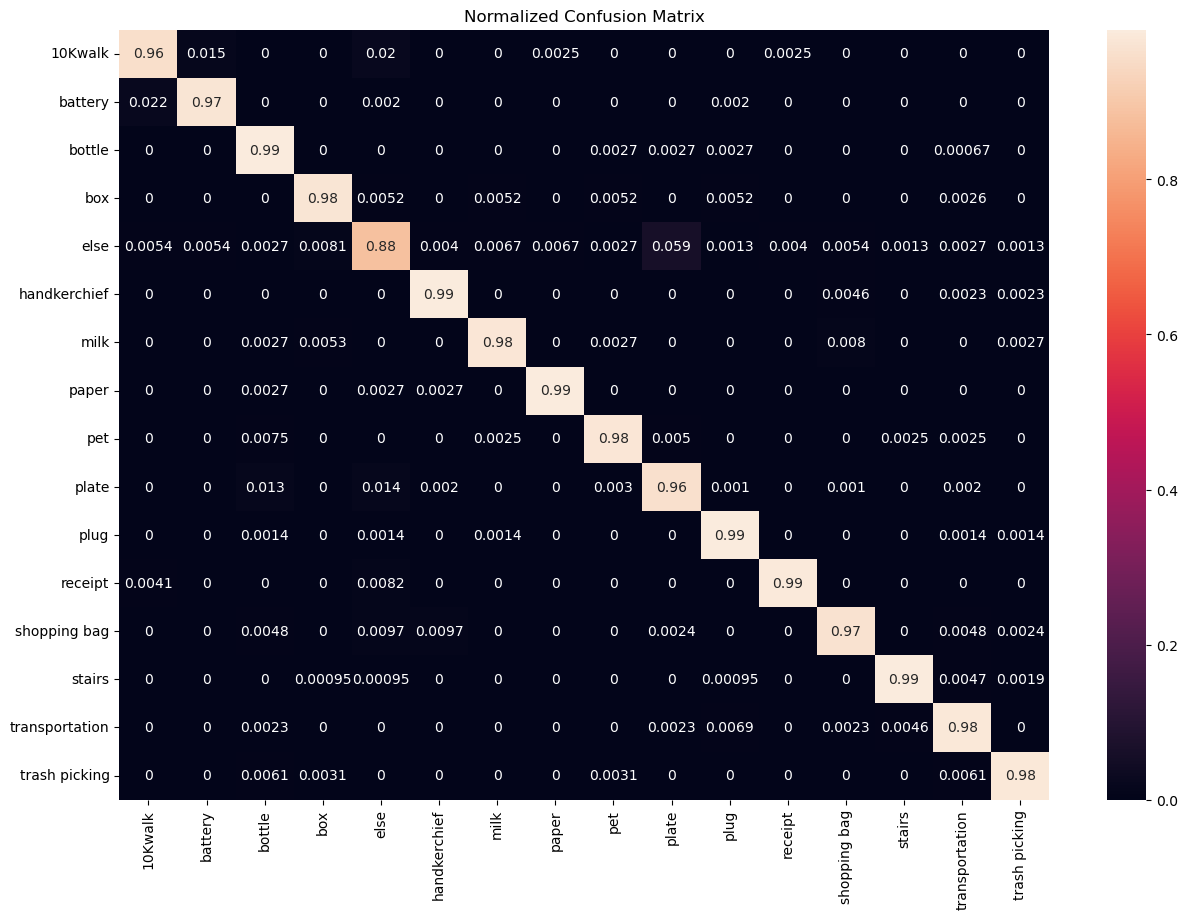

In [40]:
import seaborn as sns

test_acc = np.sum(test.label == test.pred) / len(test)
test_matrix = confusion_matrix(test['label'], test['pred'])
epoch_f1 = f1_score(test['label'], test['pred'], average='macro')
print(f'accuracy: {test_acc:.4f}')
print(f'f1_score: {epoch_f1:.4f}')

test_matrix = confusion_matrix(test['label'], test['pred'], normalize='true')
#test_matrix = confusion_matrix(test['label'], test['pred'])

plt.figure(figsize = (15,10))
sns.heatmap(test_matrix, 
            annot=True, 
            xticklabels = sorted(set(test['label'])), 
            yticklabels = sorted(set(test['label'])),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

#print(f'confusion_matrix \n-------------------------\n {test_matrix}')